In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import os
import sys
import json
import datetime
import numpy as np
import pandas as pd
import json
import random
import shutil
import imgaug as ia
import imgaug.augmenters as iaa
from skimage.morphology import label
from skimage.io import imread, imshow, concatenate_images
from skimage import color

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2

import tensorflow as tf

from tqdm.notebook import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.model import log
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [2]:
# IMPORTANT: Run this to limit GPU memory usage by tensorflow (causes Xserver crashes otherwise)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

############################################################
#  Configurations
############################################################

In [53]:
# Global variables
DATASET_DIR    = '../../data/FashionDataSet/'
SPLIT_TRAIN_DIR = os.path.join(DATASET_DIR, 'split_train' )
SPLIT_VAL_DIR = os.path.join(DATASET_DIR, 'split_val' )
LABELS_INFO_FILE    = os.path.join(DATASET_DIR, 'label_descriptions.json' )
RUN_ID = datetime.now().strftime('%Y%m-%d%H-%M%S')
WEIGHTS_DIR = os.path.join(DATASET_DIR, "weights", RUN_ID)    
WEIGHTS_FILE_PATH =  os.path.join(WEIGHTS_DIR, "mask_rcnn_imaterialist.h5")
HISTORY_FILE_PATH =  os.path.join(WEIGHTS_DIR, "history.json")

In [15]:
class FashionConfig(Config):
    """Configuration for training on the fashion dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "imaterialist"
    
    # change  backbone (Changing to resnet 50 causes less kernel crashes)
    BACKBONE = "resnet50"
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 #can change this

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # Background + 46 apparel classes

    # Batch size
    BATCH_SIZE = 32
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000
    
    # Skip detections with < 95% confidence
    DETECTION_MIN_CONFIDENCE = 0.95

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.0

############################################################
#  Dataset
############################################################

In [6]:
class FashionDataset(utils.Dataset):
    
    def __init__(self, dataset_dir):
        super(FashionDataset, self).__init__()  
        self.data_dir = dataset_dir
        self.class_names = []
        self.create_classes()
        
    def create_classes(self):
        """
        Added to FashionDataset.
        Initialize the classes.
        param:cat_file - filepath to fashion dataset's label_descriptions.json file
        """
        # read labels file
        with open(os.path.join(self.data_dir, "label_descriptions.json"), 'r') as data_file:
            labels = json.load(data_file) 
        
        categories = labels.get('categories')
        # Iterate over list of categories and create a class out of each category
        for c in categories:
            self.add_class("imaterialist", c.get('id') + 1, c.get('name')) # add 1 to make room for background
    
    def load_fashion(self, subset, frac = 1.00):
        """Load a subset of the fashion dataset.
        dataset_dir: Root directory of the dataset.
        """
        # Train or validation dataset?
        assert subset in ["train", "val"]
        if subset == "train":
            dataset_dir = os.path.join(self.data_dir, "split_train")
        else:
            dataset_dir = os.path.join(self.data_dir, "split_val")
            
        # Load image ids (filenames) and run length encoded pixels
        fashion_segmentations_df = pd.read_csv(os.path.join(dataset_dir, "info.csv"))
        # Keep track of all images in dataset
        uTotal = fashion_segmentations_df.ImageId.unique()
        nTotal = len(uTotal)
        #print("Total: {}".format(nTotal))
        
        # Return to the user a fraction of the total dataset
        batch_size = int(nTotal * frac)
        #print("Batch Size: {}".format(batch_size))

        unique_image_ids = np.random.choice(uTotal, batch_size) 
        #print("Unique: {}".format(len(unique_image_ids)))

        for image_id in tqdm(unique_image_ids, desc="Create images dict", total=len(unique_image_ids)):
            image_df = fashion_segmentations_df.loc[fashion_segmentations_df['ImageId'] == image_id]
            img_mask_list = image_df['EncodedPixels'].tolist()
            classids = image_df['ClassId'].tolist()
            classids = [ int(id.split('_')[0]) + 1 for id in classids ] # add 1 to make room for background
            image_path = os.path.join(self.data_dir, "train", image_id)
            img_width = image_df['Width'].unique()[0]
            img_height = image_df['Height'].unique()[0]

            if os.path.isfile(image_path):
                self.add_image(
                    "imaterialist",
                    image_id=image_id,  # use file name as a unique image id
                    path=image_path,
                    width=img_width, height=img_height,
                    img_masks=  {'segmentation'  : img_mask_list,
                                 'category_id'   : classids,
                                 'iscrowd'       : True, # True indicates the use of uncompressed RLE
                                 'bbox'          : [] })
        
    
    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a ship dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "imaterialist":
            return super(self.__class__, self).load_mask(image_id)

        # Convert RLE Encoding to bitmap mask of shape [height, width, instance count]
        info = self.image_info[image_id]
        img_masks = info["img_masks"]["segmentation"]
        class_ids = info["img_masks"]["category_id"]
        shape = [info["height"], info["width"]]

        # Mask array placeholder
        mask_array = np.zeros([info["height"], info["width"], len(info["img_masks"]["segmentation"])],dtype=np.uint8)

        # Build mask array
        for index, mask in enumerate(img_masks):
            mask_array[:,:,index] = self.rle_decode(mask, shape)
        return mask_array.astype(np.bool), np.array(class_ids, dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "imaterialist":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def rle_encode(self, img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def rle_decode(self, mask_rle, shape):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return
        Returns numpy array, 1 - mask, 0 - background

        '''
        if not isinstance(mask_rle, str):
            img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
            return img.reshape(shape).T

        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape((shape[1],shape[0])).T


    def masks_as_image(self, in_mask_list, shape):
        # Take the individual ship masks and create a single mask array for all apparel
        all_masks = np.zeros(shape, dtype = np.uint8)
        for mask in in_mask_list:
            if isinstance(mask, str):
                all_masks |= self.rle_decode(mask)
        return all_masks

In [7]:
def train(model, config, dataset_train, dataset_val):
    """Train the model."""
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                layers='heads')

In [49]:
def find_best(history, config, model_dir):
    minidx = np.argmin(history["val_loss"])
    # Get directory names. Each directory corresponds to a model
    dir_names = next(os.walk(MODEL_DIR))[1]
    key = config.NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)
    if not dir_names:
        import errno
        raise FileNotFoundError(
            errno.ENOENT,
            "Could not find model directory under {}".format(self.model_dir))

    # Pick last directory
    dir_name = os.path.join(MODEL_DIR, dir_names[-1])

    # Find the checkpoint based on index checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        import errno
        raise FileNotFoundError(
            errno.ENOENT, "Could not find weight files in {}".format(dir_name))
    elif minidx > len(checkpoints):
        raise Exception("Epoch index is greater than available checkpoints")
    checkpoint = os.path.join(dir_name, checkpoints[index])
    return history["val_loss"][minidx], checkpoint

## Validate the dataset object by loading a subset of the images and visualizing the images with their masks

In [8]:
dataset_train = FashionDataset(DATASET_DIR)
dataset_train.load_fashion("train", frac = 0.005)
dataset_train.prepare()

image_id  125 58940147f49f38e2ad95fb58cd2a9d41.jpg
image                    shape: (810, 1440, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (810, 1440, 4)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    2.00000  max:   34.00000  int32
bbox                     shape: (4, 4)                min:   65.00000  max: 1089.00000  int32


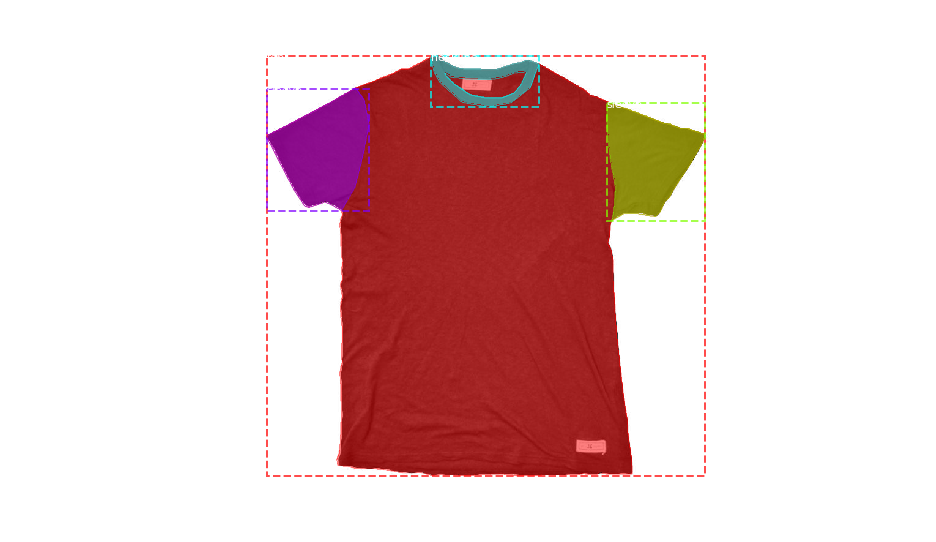

In [9]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

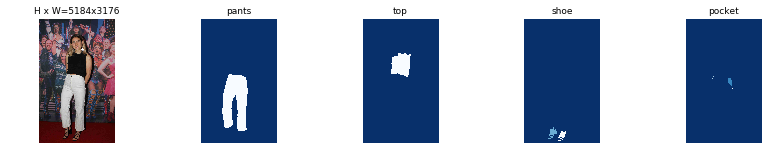

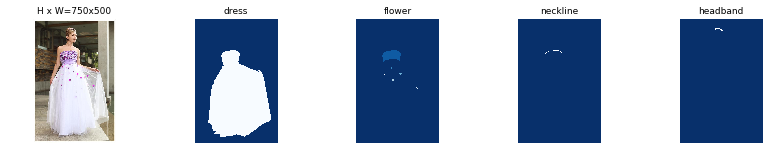

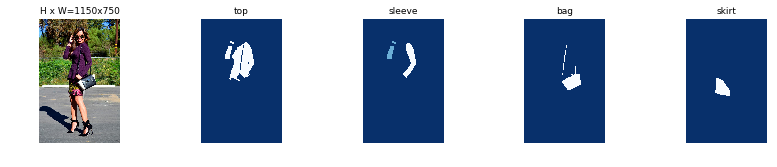

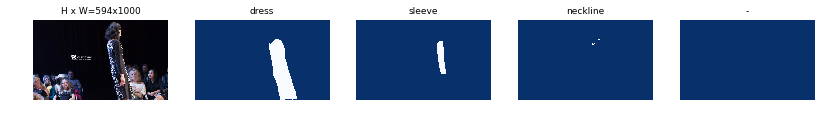

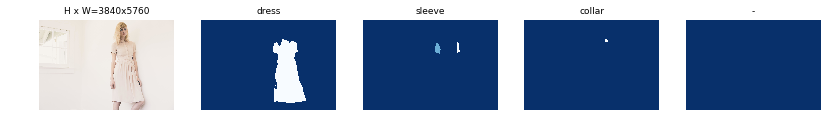

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [17]:
path, dirs, files = next(os.walk(SPLIT_TRAIN_DIR))
TRAIN_IMAGE_COUNT = len(files)

path, dirs, files = next(os.walk(SPLIT_VAL_DIR))
VAL_IMAGE_COUNT = len(files)

config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [18]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATASET_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(DATASET_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [19]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all"` to train all layers.

In [20]:
# Train dataset
dataset_train = FashionDataset(DATASET_DIR)
dataset_train.load_fashion("train")
dataset_train.prepare()
print("# Train Images: {}".format(len(dataset_train.image_ids)))

    
# Validation dataset
dataset_val = FashionDataset(DATASET_DIR)
dataset_val.load_fashion("val")
dataset_val.prepare()
print("# Val Images: {}".format(len(dataset_val.image_ids)))


# Train Images: 36596



# Val Images: 9029


In [21]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('mask_rcnn_imaterialist.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [22]:
print("[INFO] Run ID: {}".format(RUN_ID))
print("[INFO] Training network heads")
model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=20,
                    layers='heads',
                    custom_callbacks = callbacks,
                    augmentation = None)

history = model.keras_model.history.history

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: ../../data/FashionDataSet/logs/imaterialist20191207T1520/mask_rcnn_imaterialist_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_c

/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
 999/1000 [============================>.] - ETA: 0s - loss: 2.5692 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 0.8304 - mrcnn_class_loss: 0.5647 - mrcnn_bbox_loss: 0.5368 - mrcnn_mask_loss: 0.5140

/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 00000: val_loss improved from inf to 2.38985, saving model to mask_rcnn_imaterialist.h5
1000/1000 [==============================] - 542s - loss: 2.5687 - rpn_class_loss: 0.1232 - rpn_bbox_loss: 0.8298 - mrcnn_class_loss: 0.5649 - mrcnn_bbox_loss: 0.5367 - mrcnn_mask_loss: 0.5140 - val_loss: 2.3898 - val_rpn_class_loss: 0.1057 - val_rpn_bbox_loss: 0.7917 - val_mrcnn_class_loss: 0.6007 - val_mrcnn_bbox_loss: 0.4815 - val_mrcnn_mask_loss: 0.4103
Epoch 2/20
1000/1000 [==============================] - 496s - loss: 2.1762 - rpn_class_loss: 0.1009 - rpn_bbox_loss: 0.7893 - mrcnn_class_loss: 0.5083 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.3675 - val_loss: 2.0486 - val_rpn_class_loss: 0.0911 - val_rpn_bbox_loss: 0.7298 - val_mrcnn_class_loss: 0.4778 - val_mrcnn_bbox_loss: 0.3883 - val_mrcnn_mask_loss: 0.3616
Epoch 3/20
1000/1000 [==============================] - 494s - loss: 2.0878 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 0.7873 - mrcnn_class_loss: 0.4862 - mrcnn_bbox_loss: 0.38

1000/1000 [==============================] - 487s - loss: 1.7474 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 0.7334 - mrcnn_class_loss: 0.3782 - mrcnn_bbox_loss: 0.2771 - mrcnn_mask_loss: 0.2791 - val_loss: 1.6660 - val_rpn_class_loss: 0.0559 - val_rpn_bbox_loss: 0.5422 - val_mrcnn_class_loss: 0.4489 - val_mrcnn_bbox_loss: 0.3162 - val_mrcnn_mask_loss: 0.3028
Epoch 15/20
1000/1000 [==============================] - 487s - loss: 1.7590 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 0.7296 - mrcnn_class_loss: 0.3895 - mrcnn_bbox_loss: 0.2735 - mrcnn_mask_loss: 0.2799 - val_loss: 1.7999 - val_rpn_class_loss: 0.0672 - val_rpn_bbox_loss: 0.7777 - val_mrcnn_class_loss: 0.3826 - val_mrcnn_bbox_loss: 0.2869 - val_mrcnn_mask_loss: 0.2855
Epoch 16/20
 999/1000 [============================>.] - ETA: 0s - loss: 1.6941 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 0.6831 - mrcnn_class_loss: 0.3859 - mrcnn_bbox_loss: 0.2728 - mrcnn_mask_loss: 0.2741
Epoch 00015: reducing learning rate to 0.0001000000047497451

In [55]:
loss, best_weights_path = find_best(history, config, MODEL_DIR)
print("[INFO] Best Model: {} (loss:{})".format(best_weights_path,loss))

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

if os.path.exists(WEIGHTS_FILE_PATH):
    print("[WARN] Model weights file already exists, file will be overwritten")
    
print("[INFO] Saving best weights to '{}'".format(WEIGHTS_FILE_PATH))
shutil.copy(best_weights_path, WEIGHTS_FILE_PATH)

print("[INFO] Saving history to '{}'".format(HISTORY_FILE_PATH))
with open(HISTORY_FILE_PATH, 'w') as fp:
    json.dump(str(history), fp)

[INFO] Best Model: ../../data/FashionDataSet/logs/imaterialist20191207T1520/mask_rcnn_imaterialist_0038.h5 (loss:1.3187170898914338)
[WARN] Model weights file already exists, file will be overwritten
[INFO] Saving best weights to '../../data/FashionDataSet/weights/201912-0813-3637/mask_rcnn_imaterialist.h5'
[INFO] Saving history to '../../data/FashionDataSet/weights/201912-0813-3637/history.json'


In [23]:
ia.seed(1)

augmentation = iaa.Sometimes(5/6, iaa.OneOf([
                                 iaa.Fliplr(0.5), # horizontal flips
                                 iaa.Flipud(0.5), # vertical flips
                                 iaa.Crop(percent=(0, 0.1)), # random crops
                                 
                                 # Small gaussian blur with random sigma between 0 and 0.5.
                                 # But we only blur about 50% of all images.
                                 iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
                                 
                                 # Strengthen or weaken the contrast in each image.
                                 iaa.ContrastNormalization((0.75, 1.5)),
                                 
                                 # Add gaussian noise.
                                 # For 50% of all images, we sample the noise once per pixel.
                                 # For the other 50% of all images, we sample the noise per pixel AND
                                 # channel. This can change the color (not only brightness) of the
                                 # pixels.
                                 iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                                 
                                 # Make some images brighter and some darker.
                                 # In 20% of all cases, we sample the multiplier once per channel,
                                 # which can end up changing the color of the images.
                                 iaa.Multiply((0.8, 1.2), per_channel=0.2),
                                 
                                 # Apply affine transformations to each image.
                                 # Scale/zoom them, translate/move them, rotate them and shear them.
                                 
                                 iaa.Affine(scale=(0.5, 1.5)),
                                 iaa.Affine(rotate=(-45, 45)),
                                 iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
                                 iaa.Affine(shear=(-8, 8)),
                                 ]))

/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [24]:
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/10,
                epochs=40,
                layers='all',
                augmentation = augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/100,
            epochs=60,
            layers='all',
            augmentation = augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 20. LR=0.0001

Checkpoint Path: ../../data/FashionDataSet/logs/imaterialist20191207T1520/mask_rcnn_imaterialist_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

1000/1000 [==============================] - 705s - loss: 1.7224 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 0.6885 - mrcnn_class_loss: 0.4095 - mrcnn_bbox_loss: 0.2614 - mrcnn_mask_loss: 0.2850 - val_loss: 1.6006 - val_rpn_class_loss: 0.0649 - val_rpn_bbox_loss: 0.6834 - val_mrcnn_class_loss: 0.3576 - val_mrcnn_bbox_loss: 0.2409 - val_mrcnn_mask_loss: 0.2538
Epoch 31/40
1000/1000 [==============================] - 736s - loss: 1.7257 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 0.6588 - mrcnn_class_loss: 0.4222 - mrcnn_bbox_loss: 0.2715 - mrcnn_mask_loss: 0.2940 - val_loss: 1.8158 - val_rpn_class_loss: 0.0779 - val_rpn_bbox_loss: 0.8674 - val_mrcnn_class_loss: 0.3846 - val_mrcnn_bbox_loss: 0.2365 - val_mrcnn_mask_loss: 0.2495
Epoch 32/40
1000/1000 [==============================] - 697s - loss: 1.7912 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 0.7321 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.2733 - mrcnn_mask_loss: 0.3049 - val_loss: 1.8460 - val_rpn_class_loss: 0.0804 - val_rpn_bbox_

Epoch 41/60
1000/1000 [==============================] - 740s - loss: 1.6445 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.6743 - mrcnn_class_loss: 0.3822 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.2721 - val_loss: 1.6916 - val_rpn_class_loss: 0.0686 - val_rpn_bbox_loss: 0.7827 - val_mrcnn_class_loss: 0.3675 - val_mrcnn_bbox_loss: 0.2331 - val_mrcnn_mask_loss: 0.2397
Epoch 42/60
1000/1000 [==============================] - 694s - loss: 1.7800 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.7149 - mrcnn_class_loss: 0.3936 - mrcnn_bbox_loss: 0.2736 - mrcnn_mask_loss: 0.3132 - val_loss: 1.5347 - val_rpn_class_loss: 0.0603 - val_rpn_bbox_loss: 0.6464 - val_mrcnn_class_loss: 0.3475 - val_mrcnn_bbox_loss: 0.2301 - val_mrcnn_mask_loss: 0.2505
Epoch 43/60
1000/1000 [==============================] - 696s - loss: 1.6725 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 0.6419 - mrcnn_class_loss: 0.3958 - mrcnn_bbox_loss: 0.2611 - mrcnn_mask_loss: 0.2944 - val_loss: 1.3625 - val_rpn_class_loss: 0.0491 - v

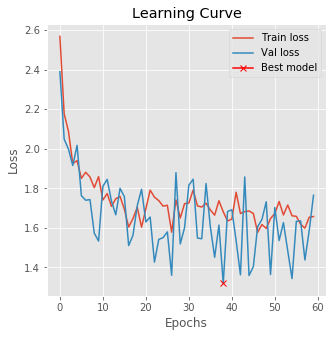

In [37]:
# plot loss
plt.figure(figsize=(5,5))
plt.plot(history["loss"], label='Train loss')
plt.plot(history["val_loss"], label='Val loss')
plt.plot(np.argmin(history["val_loss"]), np.min(history["val_loss"]), marker='x', color='r', label='Best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [59]:
loss, best_weights_path = find_best(history, config, MODEL_DIR)
print("[INFO] Best Model: {} (loss:{})".format(best_weights_path,loss))

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

if os.path.exists(WEIGHTS_FILE_PATH):
    print("[WARN] Model weights file already exists, file will be overwritten")
    
print("[INFO] Saving best weights to '{}'".format(WEIGHTS_FILE_PATH))
shutil.copy(best_weights_path, WEIGHTS_FILE_PATH)

print("[INFO] Saving history to '{}'".format(HISTORY_FILE_PATH))
with open(HISTORY_FILE_PATH, 'w') as fp:
    json.dump(str(history), fp)

[INFO] Best Model: ../../data/FashionDataSet/logs/imaterialist20191207T1520/mask_rcnn_imaterialist_0038.h5 (loss:1.3187170898914338)
[WARN] Model weights file already exists, file will be overwritten
[INFO] Saving best weights to '../../data/FashionDataSet/weights/201912-0813-3637/mask_rcnn_imaterialist.h5'
[INFO] Saving history to '../../data/FashionDataSet/weights/201912-0813-3637/history.json'


## Inference

In [62]:
class InferenceConfig(FashionConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Skip detections with < 60% confidence
    DETECTION_MIN_CONFIDENCE = 0.6

In [63]:
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [66]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
#weights_path = model.find_last()

# Load best weights for run
print("[INFO] Loading best weights for run ", WEIGHTS_FILE_PATH)
model.load_weights(WEIGHTS_FILE_PATH, by_name=True)

[INFO] Loading best weights for run  ../../data/FashionDataSet/weights/201912-0813-3637/mask_rcnn_imaterialist.h5


image ID: imaterialist.51651995cc51dc6cb3a7c99fa51addc5.jpg (32290) 51651995cc51dc6cb3a7c99fa51addc5.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (12,)                 min:    5.00000  max:   36.00000  int32
gt_bbox                  shape: (12, 4)               min:   60.00000  max:  919.00000  int32
gt_mask                  shape: (1024, 1024, 12)      min:    0.00000  max:    1.00000  bool


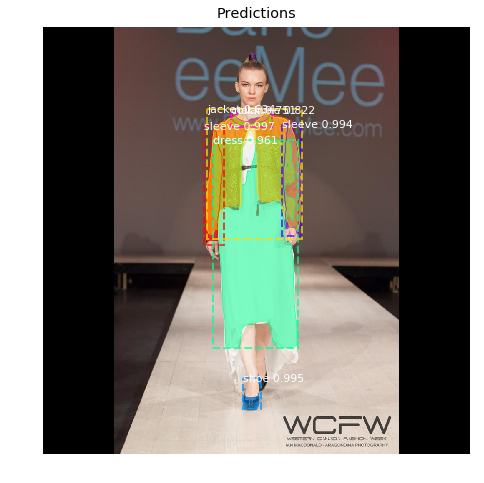

In [72]:
image_id = random.choice(dataset_train.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
info = dataset_train.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_train.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Precision-Recall

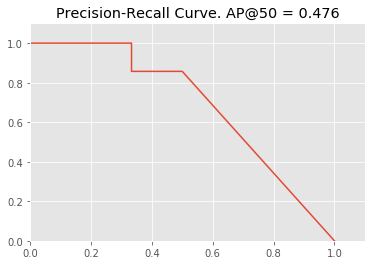

In [73]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

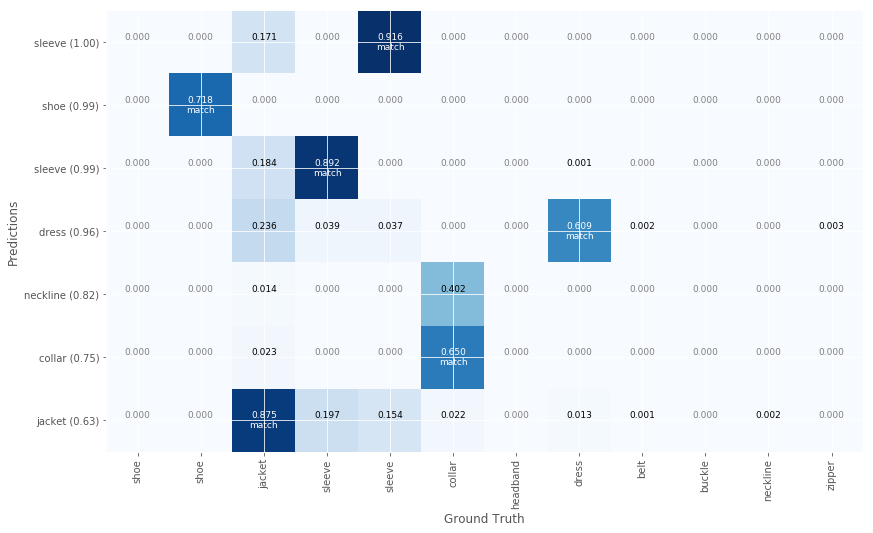

In [74]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_train.class_names)

## Compute mAP @ IoU=50 on Batch of Images¶

In [71]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_train, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset_train.image_ids, 50)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.4372165468384822
